#### Estudo de Correlação 
> Temperatura / Cobertura Vegetal
  
<sub>gds - Google Dataset</sub>  
<sub>lz - Listed Zeros</sub>  
<sub>corr - Correlation</sub>  
<sub>avr - Average</sub> 

---  

In [1]:
# Importing GEE dependencies
from helpers.geeApi import PrecorsiaGee
import ee

# Importing image processing tools
from helpers.imageCorrelator import ImageCorrelator
from helpers.imageProcessor import ImageProcessor
import matplotlib.pyplot as plt
import os

#### Image availability list

Add dataset's configuration 

In [3]:
# ! Execute once per session
PrecorsiaGee.init()

In [4]:
START = ee.Date('2020-01-01')
END = START.advance(730, 'day')
geolocation = [16.0569, 51.6608]
image_scale = 10000
round_factor = 8

In [ ]:
reference_dataset = 'GOOGLE/DYNAMICWORLD/V1'
comparable_dataset = 'UCSB-CHG/CHIRPS/DAILY'

reference_band_name, reference_band_range = 'grass', [0, 1]
comparable_band_name, comparable_band_range = 'precipitation', [0, 1]

In [2]:
gds_one = PrecorsiaGee(reference_dataset, reference_band_range)
gds_two = PrecorsiaGee(comparable_dataset, comparable_band_range)

Configure the filter and get the list of images

In [5]:
gds_one_list = gds_one.list(geolocation, [START, END])
gds_two_list = gds_two.list(geolocation, [START, END])
gds_one_list, gds_two_list = PrecorsiaGee.correlate_dates(gds_one_list, gds_two_list, round_factor)

#### Image requests and data acquisition

commit to memory

In [6]:
for id in gds_one_list:
    filename = f'./buffer/{id["id"]}.png'
    if not os.path.exists(filename):
        gds_one_image = gds_one.image(id['id'], [reference_band_name], geolocation, image_scale)
        plt.imsave(filename, gds_one_image, cmap='gray')

for id in gds_two_list:
    filename = f'./buffer/{id["id"]}.png'
    if not os.path.exists(filename):
        gds_two_image = gds_two.image(id['id'], [comparable_band_name], geolocation, image_scale)
        plt.imsave(filename, gds_two_image, cmap='gray')

#### Processing and visualizing the data

filter using zero counting

In [7]:
# ! will delete from buffer
process = ImageProcessor([gds_one_list, gds_two_list])
[gds_one_lz, gds_two_lz] = process.zero_counting_filter()

Group by date and plot a correlation graph

In [8]:
corr_list = PrecorsiaGee.connected_correlation(gds_one_lz, gds_two_lz, round_factor)

In [9]:
title = {'title': f'Correlation between {gds_one.dataset} and {gds_two.dataset} at {geolocation}',
         'xlabel': gds_one.dataset, 'ylabel': gds_two.dataset}

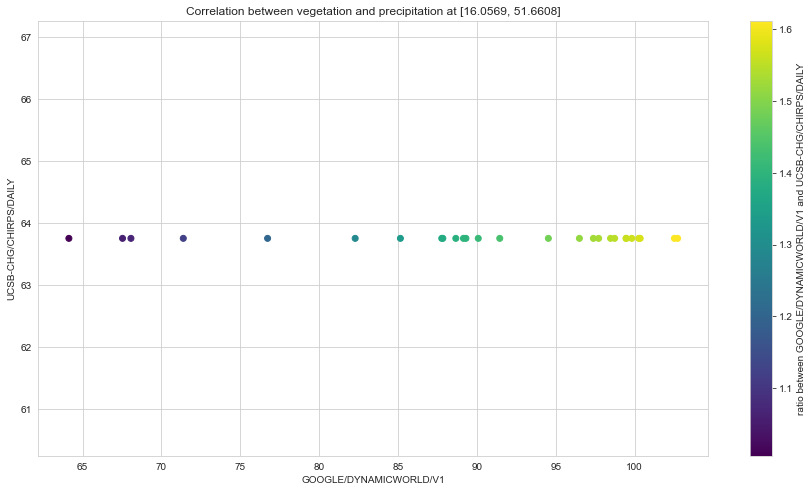

In [10]:
corr_study = ImageCorrelator(corr_list)
corr_avr = corr_study.calculate_correlation()
ImageCorrelator.plot(corr_avr, title)
plt.show()